# Carbon box model

This notebook implements the box model of Kump et al. (1999), which models the isotopic composition of the combined ocean-atmosphere system.

In [1]:
import numpy as np
import matplotlib.pyplot  as plt
plt.style.use('seaborn-talk')

<img src='Kump steady state.png' wid=400px />

## Basic theory

Guiding equations for overall ocean-atmosphere carbon reservoir $M_0$ as well as the isotopic composition of DIC in the reservoir.
$$
\frac{dM_0}{dt} = F_w + F_{volc} - (F_{b,org} - F_{b,carb}) \\
\frac{dM_0, \delta_{carb}}{dt} = F_w\,\delta_w + F_{volc}\,\delta_{volc} - F_{b,org}\,\delta_{carb} - F_{b,carb}\,(\delta_{carb} + \Delta_B) \\
$$

If we evaluate the second derivative above (using the product rule) and simplify, we arrive at the following equation for the time rate of change in the inorganic carbon isotopic composition:

$$
\frac{d \delta_{carb}}{dt} = \frac{F^\prime_w\,(\delta^\prime_w - \delta_{carb}) - F_{b,org}\,\Delta_B}{M_0}
$$

The steady state of the previous equation results in the following expression for the fraction of organic carbon burial as a function of isotopic values.

$$
f_{org} = \frac{F_{b,org}}{F^\prime_w} = \frac{\delta^\prime_w-\delta_{carb}}{\delta_{org}-\delta_{carb}}
$$

The following are relations used throughout:

$$
\Delta_B = \delta_{org} - \delta_{carb} \\
F^\prime_w = F_w + F_{volc} = F_{w, carb} + F_{w, org} + F_{volc} \\
\delta^\prime_w = \delta_w
$$

## More assumptions

Proceeding from the previous equations, which assume only that the ocean-atmosphere system is perfectly equilibrated, we make the following assumptions:

1) Assume that weathering flux into ocean-atmosphere system depends on organic and carbonate inputs,

$$
F_w = F_{w, carb} + F_{w, org}
$$

since silicate weathering only transfers carbon from the atmosphere to the ocean, it doesn't actually remove or add carbon to the combined ocean-atmosphere system. 

2) Assume that carbonate ion and therefore carbonate mineral burial rate respond much faster than the reservoir to changes in fluxes, so burial rate is basically always equilibrated from the frame of reference of the reservoir.

$$
F_{b,carb} = F_{w, carb} + F_{w, sil}
$$

Adding these assumptions into the first mass balance equation generates the following expression:

$$
\frac{dM_0}{dt} = F_{w, org} + F_{volc} - F_{b, org} - F_{w, sil}
$$

## Guiding equations

Thus, the basic governing equations are the following two. Note that the first equation differs somewhat from equation (3) in the paper because the authors lump the weathering fluxes and isotopic compositions into one flux despite actually later experimenting with changing the organic carbon weathering flux. I prefer to keep all of the terms explicitly separated.

\begin{align}
\frac{d \delta_{carb}}{dt} &= \frac{F_{w, carb}\,(\delta_{w, carb} - \delta_{carb}) + F_{w, org}\,(\delta_{w, org} - \delta_{carb}) + F_{volc}\,(\delta_{volc} - \delta_{carb}) - F_{b,org}\,\Delta_B}{M_0} \\
\frac{dM_0}{dt} &= F_{w, org} + F_{volc} - F_{b, org} - F_{w, sil}
\end{align}

The second equation is correct, however, and encodes the assumptions expressed above.

Other necessary relations, relate atmospheric carbon to relative reservoir size change, and use atmospheric carbon to get at extent of biological fractionation. 

$$
\text{pCO}_2(t) = \left( \frac{M_0(t)}{M_0(0)} \right)^2\,\text{pCO}_2(0) \\
\Delta_B = \left( \frac{159.5\mathrm{[PO_4]} + 38.39}{0.034\,\mathrm{pCO_2}} \right) - 33
$$

### Initialization and model functions

As in the paper, all reservoirs are in units of $10^{12}$ mol C, and fluxes are in units of $10^{12}$ mol C kyr$^{-1}$.

In [9]:
alpha = 0.75 # scaling parameter for flux of primary production from reactive phosphorus reservoir
f_preserve = 0.01 # fraction of organic matter that survives to be buried
cp = 1e16/3.5e14/f_preserve/alpha # redfield

# initialize reservoirs
atm = 1e5
ocn = 3.8e6
M0 = atm + 1.4*ocn
MP10 = 4e1  # particulate organic phosphorus
MP20 = 10000/cp/(f_preserve*alpha)  # reactive phosphorus

# time step (kyr)
dt = 1
nt = int(1500/dt) # we want to simulate 1500 kyr

# other initial values
P0 = 0.25 # phosphate concentration (micromol/kg)
pCO20 = 560 # atmospheric carbon concentration (ppmv)

In [10]:
# biological fractionation extent
def DeltaB(P, pCO2):
    return ((159.5*P+38.39)/(0.034*pCO2) - 33)

# pCO2 for constant DeltaB
def pCO2_DBconst(P, DB):
    return (1/0.034)*((159.5*P + 38.39)/(DB + 33))

# atmospheric carbon concentration
def pCO2(M):
    return ((M/M0)**2 * pCO20)

Kump et al. define fluxes using a prescribed steady state configuration shown in their Figure 1, and any deviation from these fluxes lasts for 500 kyr. The following functions then return either $nt$ of the steady state values, where $nt$ is the number of simulated time steps of duration $dt$, or a user-specified forcing perturbation lasting 500 kyr before returning to steady state values.

In the paper, the authors apparently apply the forcing after 100 kyr of steady state, so we will do the same.

In [11]:
# define fluxes

# volcanic
def F_volc(force=[]):
    out = 6000*np.ones(nt)
    if not force:
        return out
    else:
        force_idx = slice(int(100/dt), int(600/dt))
        out[force_idx] = force
        return out

# silicate weathering
def F_wsil(force=[]):
    out = 6000*np.ones(nt)
    if not force:
        return out
    else:
        force_idx = slice(int(100/dt), int(600/dt))
        out[force_idx] = force
        return out

# carb weathering
def F_wcarb(force=[]):
    out = 34000*np.ones(nt)
    if not force:
        return out
    else:
        force_idx = slice(int(100/dt), int(600/dt))
        out[force_idx] = force
        return out

# organic weathering
def F_worg(force=[]):
    out = 10000*np.ones(nt)
    if not force:
        return out
    else:
        force_idx = slice(int(100/dt), int(600/dt))
        out[force_idx] = force
        return out

# organic burial
# def F_borg(force=[]):
#     out = 10000*np.ones(nt)
#     if not force:
#         return out
#     else:
#         force_idx = slice(int(100/dt), int(600/dt))
#         out[force_idx] = force
#         return out

# carbonate burial
def F_bcarb(force=[]):
    out = 40000*np.ones(nt)
    if not force:
        return out
    else:
        force_idx = slice(int(100/dt), int(600/dt))
        out[force_idx] = force
        return out

In [12]:
# define isotopic compositions

# organic carbon weathering isotopic value
def d_worg():
    out = -22*np.ones(nt)
    return out

# volcanic isotopic value
def d_volc():
    out = -5*np.ones(nt)
    return out

# carbonate weathering isotopic value
def d_wcarb():
    out = 0*np.ones(nt)
    return out

In [13]:
# phosphate concentration in micromol/kg
def PO4(MP2):
    return MP2*1e12/1.4e21/1e-6
    
# riverine phosphorus (in units of 10e12 mol/kyr), steady state is 4e13 mol/kyr (similar to Van Cappellen)
def F_P_riv(force=[]):
    out = 10000/cp*np.ones(nt)
    if not force:
        return out
    else:
        force_idx = slice(int(100/dt), int(600/dt))
        out[force_idx] = force
        return out
    
# primary production phosphorus, reactive phosphorus reservoir M2
def F21_P(M2):
    return alpha*M2

# fraction of organic material the is actually buried
def F12_P(F21):
    return F21-f_preserve*F21

# burial flux in 10e12 mol/kyr of carbon!
# redfield burial of 250
def F_borgC(F21):
    return cp*f_preserve*F21

# phosphorus burial flux in 10e12 mol/kyr
def F_borgP(F21):
    return f_preserve*F21

## Sanity check

Let's reproduce their steady state isotopic values, i.e. $\Delta_B = \delta_{org} - \delta_{carb} = -29$ and $\delta_{carb} = 0.78$.

In [14]:
def model(d_carbt, DBt, pCO2t, Mt, MP1t, MP2t, DBconst=False):
    # arrays to hold model outputs
    d_carb = np.zeros(nt)
    d_org = np.zeros(nt)
    DB = np.zeros(nt)
    M = np.zeros(nt)
    MP1 = np.zeros(nt)
    MP2 = np.zeros(nt)
    pCO2_out = np.zeros(nt)
    F_borg_out = np.zeros(nt)

    for tt in range(nt):
    
        # solve phosphorus model
        F21_Pt = F21_P(MP2t)
        F12_Pt = F12_P(F21_Pt)
        MP2[tt] = MP2t + dt*(F_P_riv_in[tt] - F21_Pt + F12_Pt)
        
        F_borgPt = F_borgP(F21_Pt)
        F_borgCt = F_borgC(F21_Pt)
        F_borg_out[tt] = F_borgCt
        MP1[tt] = MP1t + dt*(F21_Pt - F_borgPt - F12_Pt)
    
        # solve DeltaB equation
        if DBconst:
#             pCO2_out[tt] = pCO2_DBconst(P[tt], DBt)
            pCO2_out[tt] = pCO2(Mt)
            DB[tt] = DBt
        else:
            # solve pCO2 equation
            pCO2_out[tt] = pCO2(Mt)
            DB[tt] = DeltaB(PO4(MP2t), pCO2t)
#             DB[tt] = DeltaB(P0, pCO2t)

        # solve reservoir equation
        M[tt] = Mt + dt*(F_worg_in[tt] + F_volc_in[tt] - F_borgCt - F_wsil_in[tt])

        # solve dcarb equation
#         pdb.set_trace()
        d_carb[tt] = d_carbt + dt/Mt * (F_wcarb_in[tt]*(d_wcarb_in[tt]-d_carbt) + \
                                        F_worg_in[tt]*(d_worg_in[tt]-d_carbt) + \
                                        F_volc_in[tt]*(d_volc_in[tt]-d_carbt) - \
                                        F_borgCt*DBt)

        # update values
        pCO2t = pCO2_out[tt]
        DBt = DB[tt]
        d_carbt = d_carb[tt]
        Mt = M[tt]
        MP2t = MP2[tt]
        MP1t = MP1[tt]
    
    return d_carb, DB, M, pCO2_out, MP1, MP2, F_borg_out

In [16]:
# model inputs
F_volc_in = F_volc()
F_wsil_in = F_wsil()
F_wcarb_in = F_wcarb()
F_worg_in = F_worg()
# F_borg_in = F_borg()
F_bcarb_in = F_bcarb()
d_worg_in = d_worg()
d_volc_in = d_volc()
d_wcarb_in = d_wcarb()
F_P_riv_in = F_P_riv()

# initial values
d_carbt = 0
d_orgt = -25
DBt = d_orgt - d_carbt
pCO2t = pCO20
Mt = M0
MP1t = MP10
MP2t = MP20

d_carb, DB, M, pCO2_out, MP1, MP2, F_borg_out = model(d_carbt, DBt, pCO2t, Mt, MP1t, MP2t)

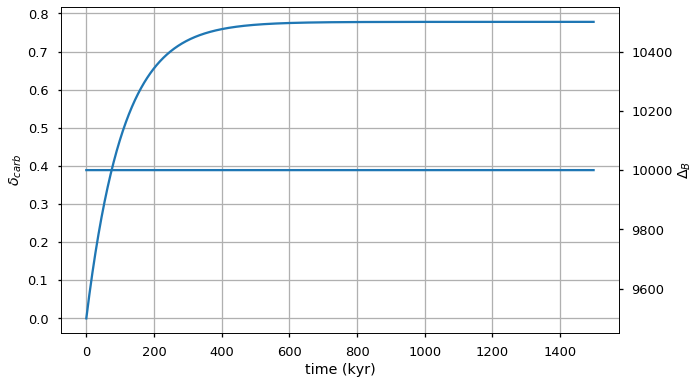

In [17]:
plt.figure(figsize=(10,6))
ax1 = plt.axes()
ax2 = ax1.twinx()

ax1.plot(d_carb)
ax1.set_xlabel('time (kyr)')
ax1.set_ylabel('$\delta_{carb}$')
ax1.grid()

ax2.plot(F_borg_out)
ax2.set_ylabel('$\Delta_B$')

plt.show()

## 3.1.1 Increased riverine phosphate delivery

Here reproduce their figures 3 & 4.

Apparently their approach involves another coupled box model for phosphorus, which I will reverse-engineer as having two reservoirs:

1) biomass (particulate organic P)
    - M = 18e12 mol P
    - F_in = primary production (F21)
    - F_out = F_{b,org} + remineralization (F12)
    
2) reactive phosphate 
    - M = 4e15 mol P (such that 100,000 years x steady state 4e10 mol/yr = M)
    - F_in = riverine (Fin) + remineralization
    - F_out = primary production
    
Hence I ignore authigenic phosphate removal and sorption and just relate phosphorus to primary production and burial.

As per Van Cappellen, primary production scales with the size of the reactive reservoir. Also, I follow Kump by saying that preserved organic matter is 0.01 of primary production.

- $F_{21} = \alpha\,M_2$ where $\alpha \approx 11.8$
- $F_{b, org} = 0.01 \, F_{21}$

Steady-state riverine input is 4e13 mol/kyr.

### Figure 3

In [20]:
# model inputs
F_volc_in = F_volc()
F_wsil_in = F_wsil()
F_wcarb_in = F_wcarb()
F_worg_in = F_worg()
F_bcarb_in = F_bcarb()
d_worg_in = d_worg()
d_volc_in = d_volc()
d_wcarb_in = d_wcarb()
F_P_riv_in = F_P_riv(force=10000/cp*1.5)

# initial values
d_carbt = 0.7778
DBt = -29
pCO2t = pCO20
Mt = M0
MP1t = MP10
MP2t = MP20

d_carb, DB, M, pCO2_out, MP1, MP2, F_borg_out = model(d_carbt, DBt, pCO2t, Mt, MP1t, MP2t, DBconst=True)

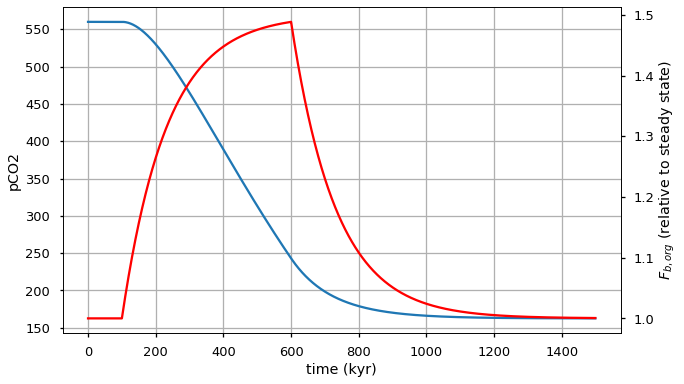

In [21]:
# figure 3a
plt.figure(figsize=(10,6))
ax1 = plt.axes()
ax2 = ax1.twinx()

ax1.plot(pCO2_out)
ax1.set_xlabel('time (kyr)')
ax1.set_ylabel('pCO2')
ax1.grid()

ax2.plot(F_borg_out/F_borg_out[0], 'r-')
ax2.set_ylabel('$F_{b,org}$ (relative to steady state)')

plt.show()

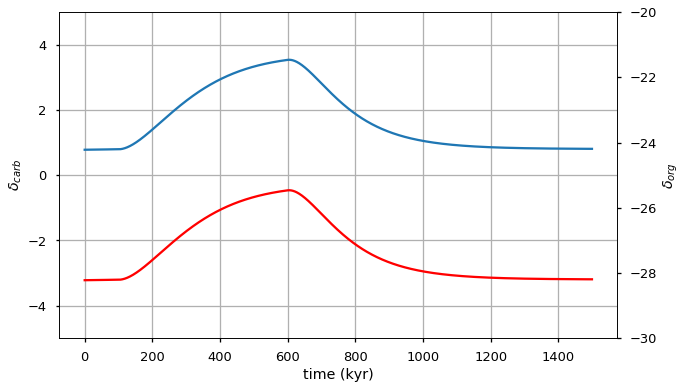

In [22]:
# figure 3b
plt.figure(figsize=(10,6))
ax1 = plt.axes()
ax2 = ax1.twinx()

ax1.plot(d_carb)
ax1.set_xlabel('time (kyr)')
ax1.set_ylabel('$\delta_{carb}$')
ax1.set_ylim([-5, 5])
ax1.grid()

ax2.plot(DB+d_carb, 'r-')
ax2.set_ylabel('$\delta_{org}$')
ax2.set_ylim([-30, -20])

plt.show()

### Figure 4

In [23]:
# model inputs
F_volc_in = F_volc()
F_wsil_in = F_wsil()
F_wcarb_in = F_wcarb()
F_worg_in = F_worg()
F_bcarb_in = F_bcarb()
d_worg_in = d_worg()
d_volc_in = d_volc()
d_wcarb_in = d_wcarb()
F_P_riv_in = F_P_riv(force=10000/cp*1.5)

# initial values
d_carbt = 0.7778
DBt = -29
pCO2t = pCO20
Mt = M0
MP1t = MP10
MP2t = MP20

d_carb, DB, M, pCO2_out, MP1, MP2, F_borg_out = model(d_carbt, DBt, pCO2t, Mt, MP1t, MP2t, DBconst=False)

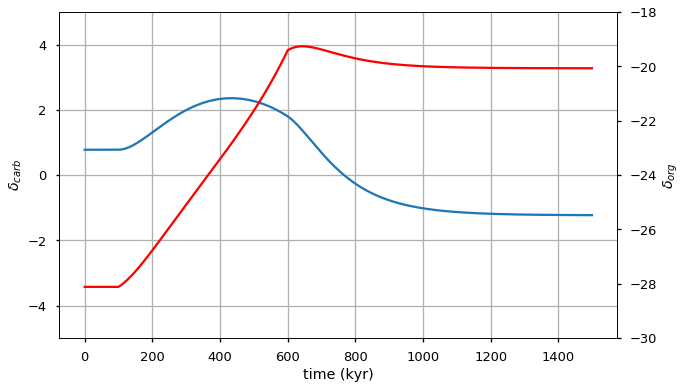

In [24]:
# figure 4
plt.figure(figsize=(10,6))
ax1 = plt.axes()
ax2 = ax1.twinx()

ax1.plot(d_carb)
ax1.set_xlabel('time (kyr)')
ax1.set_ylabel('$\delta_{carb}$')
ax1.set_ylim([-5, 5])
ax1.grid()

ax2.plot(DB+d_carb, 'r-')
ax2.set_ylabel('$\delta_{org}$')
ax2.set_ylim([-30, -18])

plt.show()

### Figure 5

In [25]:
# model inputs
F_volc_in = F_volc()
F_wsil_in = F_wsil(force=6000*1.5)
F_wcarb_in = F_wcarb(force=34000*1.5)
F_worg_in = F_worg(force=10000*1.5)
F_bcarb_in = F_bcarb()
d_worg_in = d_worg()
d_volc_in = d_volc()
d_wcarb_in = d_wcarb()
F_P_riv_in = F_P_riv(force=10000/cp*1.5)

# initial values
d_carbt = 0.7778
DBt = -29
pCO2t = pCO20
Mt = M0
MP1t = MP10
MP2t = MP20

d_carb, DB, M, pCO2_out, MP1, MP2, F_borg_out = model(d_carbt, DBt, pCO2t, Mt, MP1t, MP2t, DBconst=False)

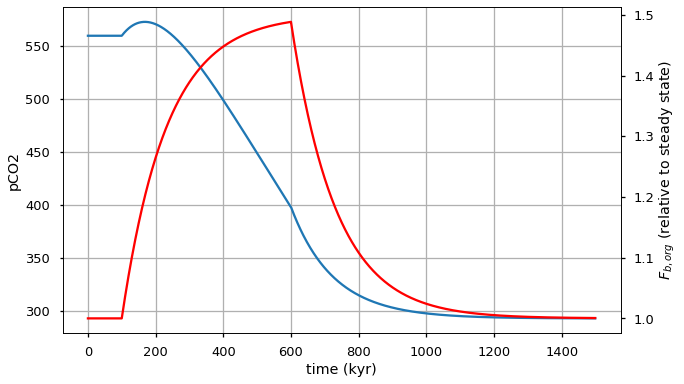

In [26]:
# figure 5a
plt.figure(figsize=(10,6))
ax1 = plt.axes()
ax2 = ax1.twinx()

ax1.plot(pCO2_out)
ax1.set_xlabel('time (kyr)')
ax1.set_ylabel('pCO2')
ax1.grid()

ax2.plot(F_borg_out/F_borg_out[0], 'r-')
ax2.set_ylabel('$F_{b,org}$ (relative to steady state)')

plt.show()

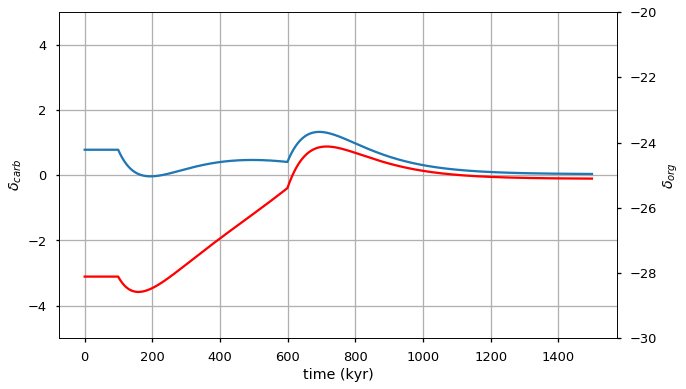

In [27]:
# figure 5b
plt.figure(figsize=(10,6))
ax1 = plt.axes()
ax2 = ax1.twinx()

ax1.plot(d_carb)
ax1.set_xlabel('time (kyr)')
ax1.set_ylabel('$\delta_{carb}$')
ax1.set_ylim([-5, 5])
ax1.grid()

ax2.plot(DB+d_carb, 'r-')
ax2.set_ylabel('$\delta_{org}$')
ax2.set_ylim([-30, -20])

plt.show()